In [1]:
import os
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sql
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [ ]:
# Get the current working directory
cwd = os.getcwd()


In [4]:
# create engine to hawaii.sqlite
engine = sql.create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#inspect what engine looks like 
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [6]:
#Inpect the engine to get table names within
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
#Connect engine
engine.connect()

In [8]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(autoload_with = engine)

In [9]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = base.classes.measurement 
Station = base.classes.station

In [11]:
# Create our session (link) from Python to the DBt
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [13]:
#get columns of the Measurement table
for column in inspector.get_columns('measurement'):#this is the data within the table (class)
        print(column['name'])

id
station
date
prcp
tobs


In [14]:
# Starting from the most recent data point in the database. 
#most_recent_data_point = session.query(Measurement).order_by(desc(Measurement.date)).first() # desc needs to be imported and clearly EDX wants func
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()# has to be scalar to pull a single point

#convert to datetime
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d').date()
most_recent_date

datetime.date(2017, 8, 23)

In [15]:
most_recent_data_point = session.query(Measurement).filter(Measurement.date == most_recent_date).first()

#check that most recent data point is the same as most recent date
print(most_recent_data_point.date) # need to use .date here to pull the value, otherwise we're just in an intermediary query


2017-08-23


In [16]:
# Calculate the date one year from the last date in data set.
one_year_prior_date = most_recent_date - dt.timedelta(days=365)
one_year_prior_date

datetime.date(2016, 8, 23)

In [17]:
# Perform a query to retrieve the data and precipitation scores
date_and_precip_scores = []
date_and_precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_prior_date).all()
#.all() required or it would be still be in form of a SQLAlchemy query object, not the actual data itself
                                                                                  
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(date_and_precip_scores, columns = ['Date','Precipitation'])
df_precipitation =df_precipitation.set_index('Date') #reset index

# Sort the dataframe by date
df_precipitation = df_precipitation.sort_index(ascending=True)
display(df_precipitation)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


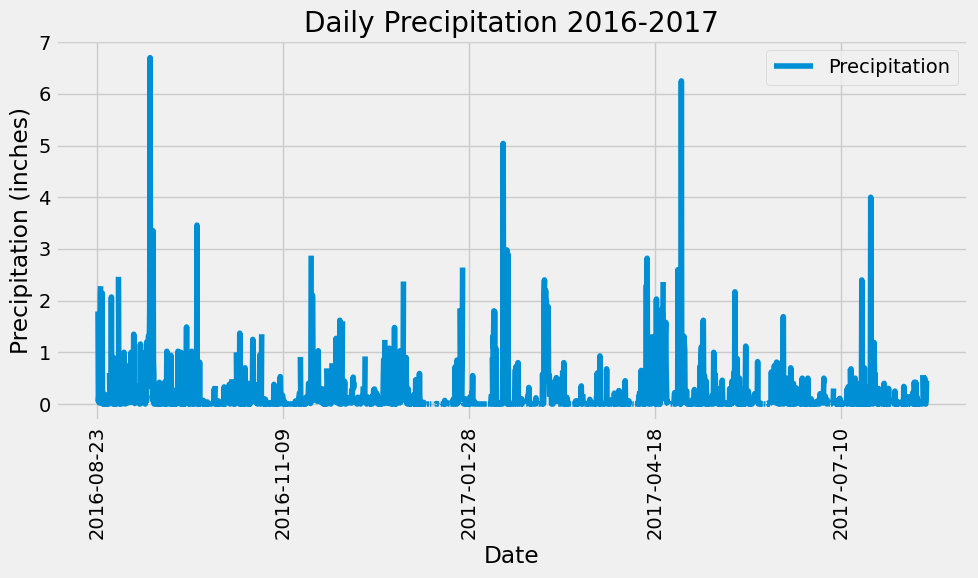

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data

#Failed attempt 1-- raw plt.plot-- won't plot to 60 days
# plt.plot(df_precipitation.index, # x-axis is the index not the ['Date'] column because Date is index
#          df_precipitation['Precipitation'], #y-axis
#          label = 'Precipitation'
#         )
# plt.title("Last Year's Precipitation")
# plt.xlabel('Date')
# plt.ylabel('Precipitation (inches)')

# #set xticks monthly(ish)- every 60 days
# tick_position = range(0, len(df_precipitation.index),60)
# tick_label = df_precipitation.index[tick_position].strftime('%Y-%m-%d')
# plt.xticks(tick_position, 
#            tick_label, 
#            rotation=90)

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
df_precipitation.plot(ax = ax, #index is inherent to pandas
                      y='Precipitation', 
                      label='Precipitation'
                     )
plt.xlabel('Date')  # Assuming index represents dates
plt.ylabel('Precipitation (inches)')  
plt.title('Daily Precipitation 2016-2017')
plt.xticks(rotation=90)  # Rotate x-axis labels for legibility
plt.savefig(os.path.join(cwd,"prcp.png")
plt.show()

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_precipitation.describe()
print(df_precipitation.describe())

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations_tuple = session.query(func.count(Station.station)).all()
number_of_stations = number_of_stations_tuple[0][0] #sqlalchemy provides a tuple in a list, need to map to correct item within that tuple within that list-- the first one
print(f'There are {number_of_stations} stations in this dataset.')

There are 9 stations in this dataset.


In [61]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# this counts the stations in the station column, groups them by station and orders the counts in decending order. 
# creates another set of tuples inside of a list 
activity_of_stations = session.query(Measurement.station, 
              func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all() # needs parentheses because otherwise it's a method

#alternative execute method
# from sqlalchemy import text
# sql = """
#  SELECT station, COUNT(station) AS station_count
#     FROM Measurement
#     GROUP BY station
#     ORDER BY station_count DESC
#  """
# results = session.execute(text(sql)).fetchall()

#set initial values for for loop 
max_station = None
max_count = -1

#for look to find the max station count within the activity list of tuples
for station, count in activity_of_stations: 
    if count > max_count:
        max_count = count
        max_station = station

print(f'The most active station is {max_station} with {max_count} data rows.')

The most active station is USC00519281 with 2772 data rows.


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [23]:
# Using the most active station id, query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [24]:
# Close Session
session.close()